In [7]:
import numpy as np
from dense_subgraph import sdp, qp
import utils
import nested_cv
from de_transformer import DiscriminativeEdgesTransformer
from cs_transformer import ContrastSubgraphTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [8]:
DATASET_NAME = "male"

In [9]:
A_GRAPH_DIR = f"./datasets/{DATASET_NAME}/asd/"
B_GRAPH_DIR = f"./datasets/{DATASET_NAME}/td/"
a_label="ASD"
b_label="TD"

In [10]:
# Read brain graph files into numpy arrays
graphs_A = utils.get_graphs_from_files(A_GRAPH_DIR)
graphs_B = utils.get_graphs_from_files(B_GRAPH_DIR)

graphs, labels = utils.label_and_concatenate_graphs(graphs_A=graphs_A, graphs_B=graphs_B, a_label=a_label, b_label=b_label)

[{'results': {'report': {'ASD': {'precision': 0.5342465753424658,
     'recall': 0.4642857142857143,
     'f1-score': 0.4968152866242039,
     'support': 84},
    'TD': {'precision': 0.5263157894736842,
     'recall': 0.5952380952380952,
     'f1-score': 0.5586592178770949,
     'support': 84},
    'accuracy': 0.5297619047619048,
    'macro avg': {'precision': 0.530281182408075,
     'recall': 0.5297619047619048,
     'f1-score': 0.5277372522506494,
     'support': 168},
    'weighted avg': {'precision': 0.5302811824080751,
     'recall': 0.5297619047619048,
     'f1-score': 0.5277372522506495,
     'support': 168}},
   'confusion_matrix': array([[39, 45],
          [34, 50]])},
  'params': {'DiscriminativeEdgesTransformer': {'a_label': 'ASD',
    'b_label': 'TD',
    'num_edges': 4},
   'SVC': {'C': 100, 'gamma': 1e-05}},
  'trained_pipeline_steps': [<de_transformer.DiscriminativeEdgesTransformer at 0x7fd9d54e0640>,
   StandardScaler(),
   SVC(C=100, gamma=1e-05)]},
 {'results': {'rep

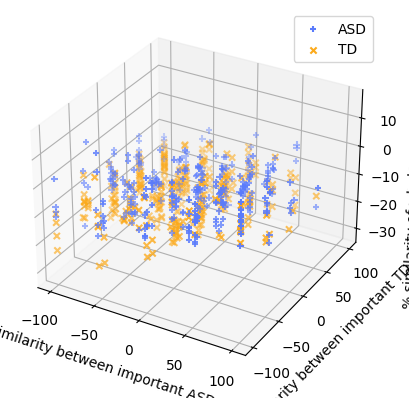

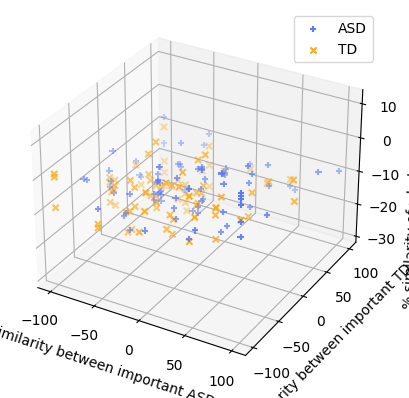

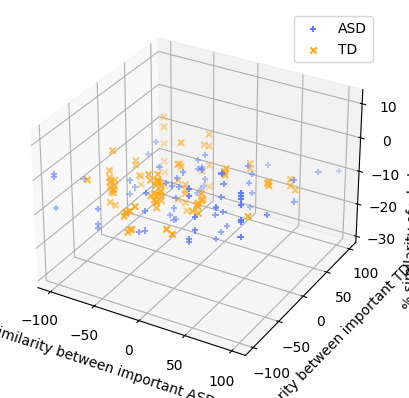

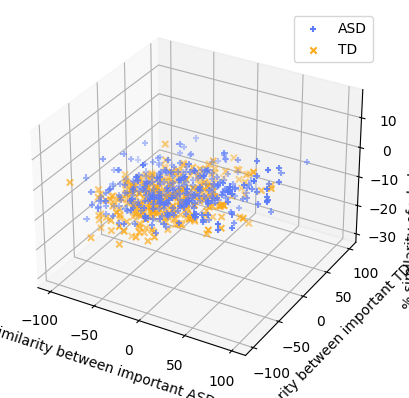

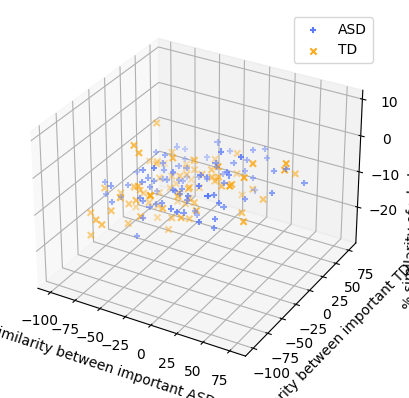

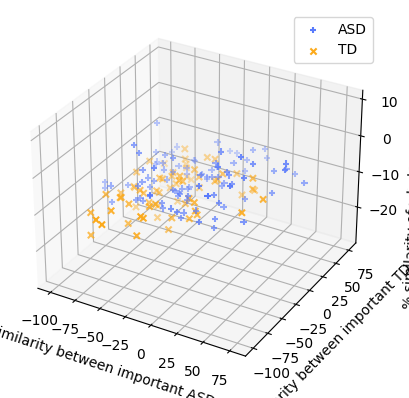

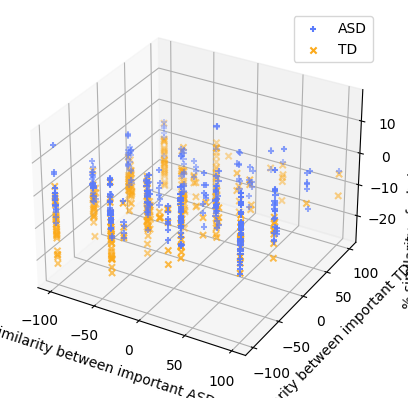

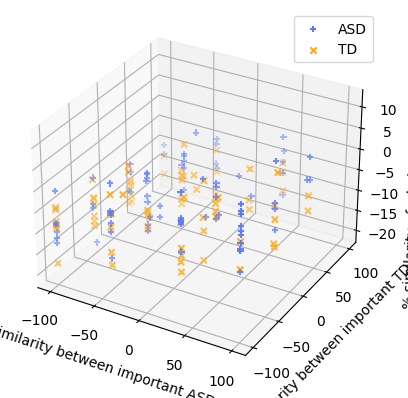

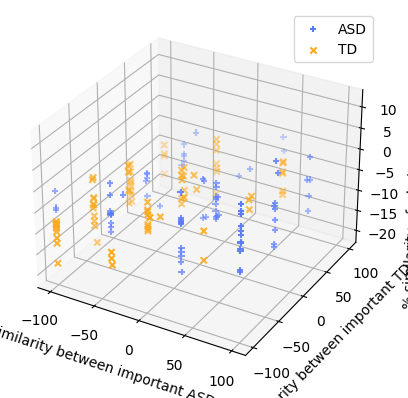

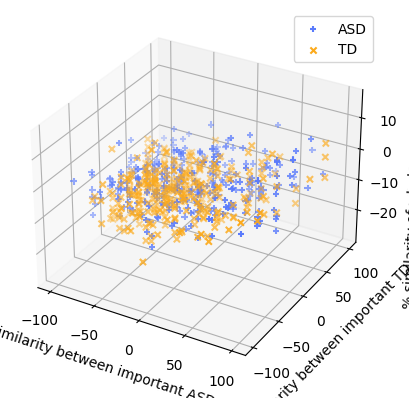

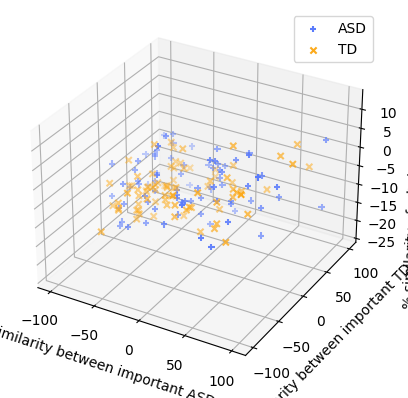

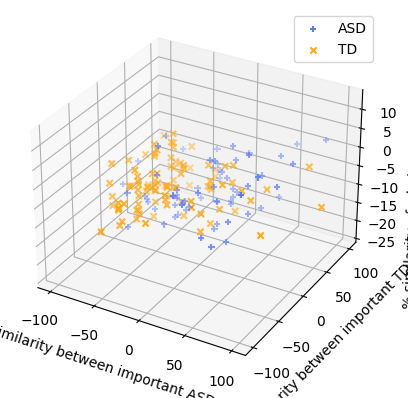

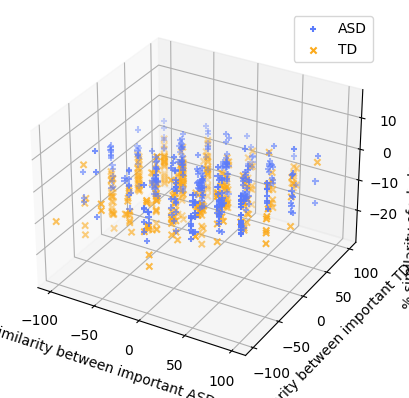

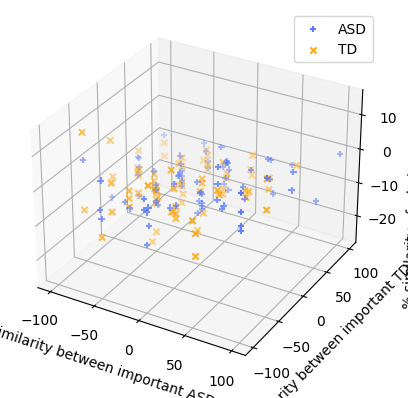

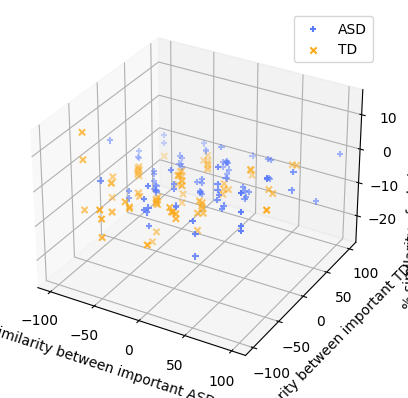

In [11]:
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.01, 0.1, 0.5, 1, 10, 50, 100], "gamma": [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1]},
          "DiscriminativeEdgesTransformer": {
            "a_label": [a_label],
            "b_label": [b_label],
            "num_edges": [2, 3, 4, 5, 6, 7, 8, 9],
            }
          }

pipe = [DiscriminativeEdgesTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = nested_cv.classify(X=graphs, y=labels, pipeline_steps=pipe, step_params=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, random_state=42, plot_prefix=DATASET_NAME)
results

alpha = 0.03731343283582089 (75-th percentile)
alpha = 0.03731343283582089 (75-th percentile)
alpha = 0.04850746268656725 (85-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.04477611940298504 (80-th percentile)
alpha = 0.03731343283582089 (75-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.05970149253731344 (90-th percentile)
alpha = 0.04477611940298504 (80-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.04850746268656725 (85-th percentile)
alpha = 0.04477611940298504 (80-th percentile)
alpha = 0.04850746268656725 (85-th percentile)
alpha = 0.04477611940298504 (80-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.04477611940298504 (80-th percentile)
alpha = 0.05970149253731344 (90-th percentile)
alpha = 0.033582089552238806 (70-th percentile)
alpha = 0.03731343283582089 (75-th percentile)
alpha 

[{'results': {'report': {'ASD': {'precision': 0.5185185185185185,
     'recall': 0.5,
     'f1-score': 0.509090909090909,
     'support': 84},
    'TD': {'precision': 0.5172413793103449,
     'recall': 0.5357142857142857,
     'f1-score': 0.5263157894736843,
     'support': 84},
    'accuracy': 0.5178571428571429,
    'macro avg': {'precision': 0.5178799489144317,
     'recall': 0.5178571428571428,
     'f1-score': 0.5177033492822967,
     'support': 168},
    'weighted avg': {'precision': 0.5178799489144317,
     'recall': 0.5178571428571429,
     'f1-score': 0.5177033492822967,
     'support': 168}},
   'confusion_matrix': array([[42, 42],
          [39, 45]])},
  'params': {'ContrastSubgraphTransformer': {'a_label': 'ASD',
    'alpha': None,
    'alpha2': None,
    'b_label': 'TD',
    'num_cs': 1,
    'percentile': 80,
    'percentile2': 70,
    'problem': 2,
    'solver': <function dense_subgraph.qp(diff_net, alpha)>},
   'SVC': {'C': 100, 'gamma': 0.001}},
  'trained_pipeline_ste

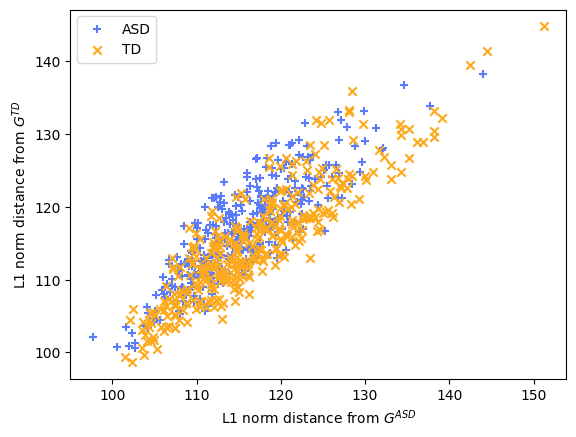

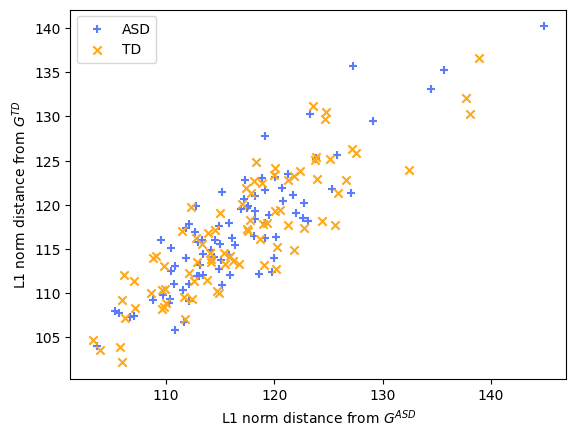

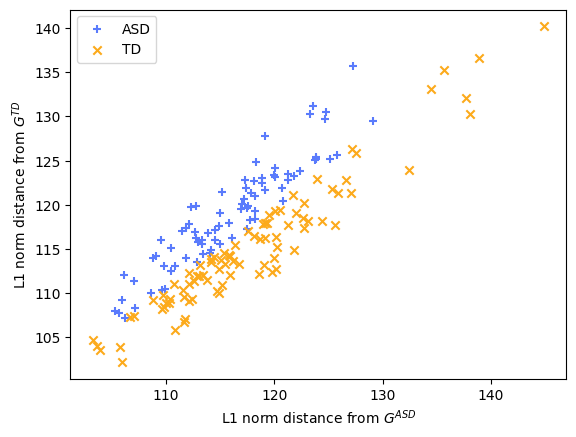

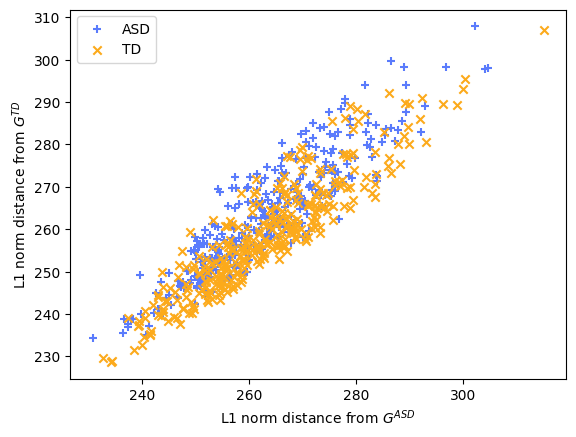

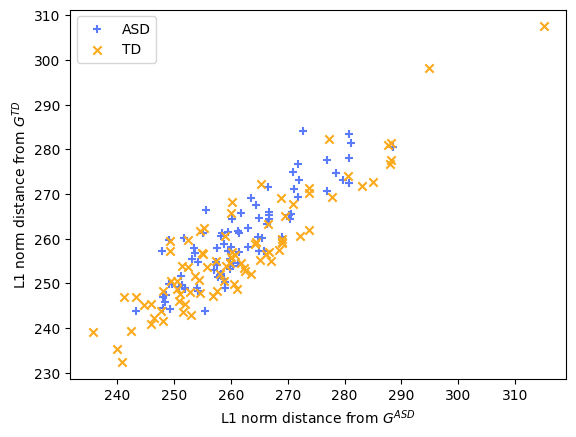

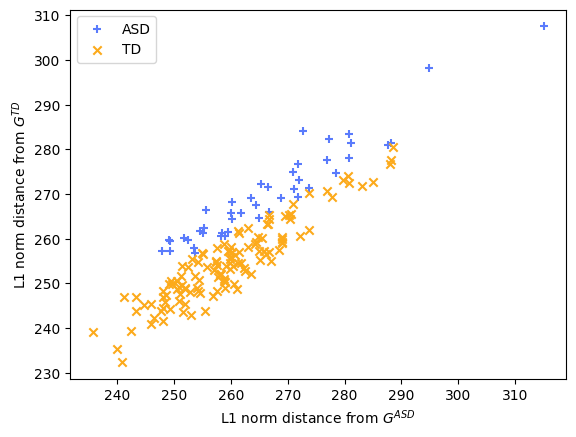

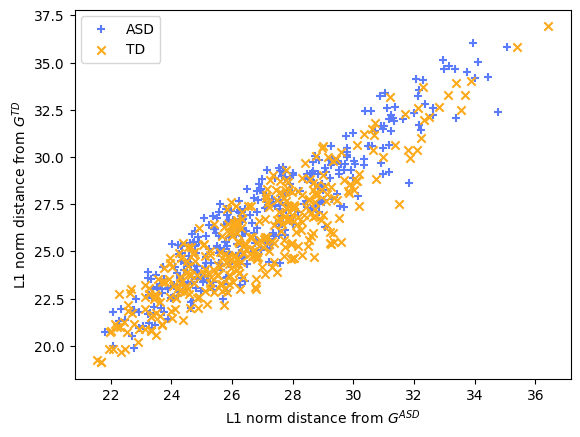

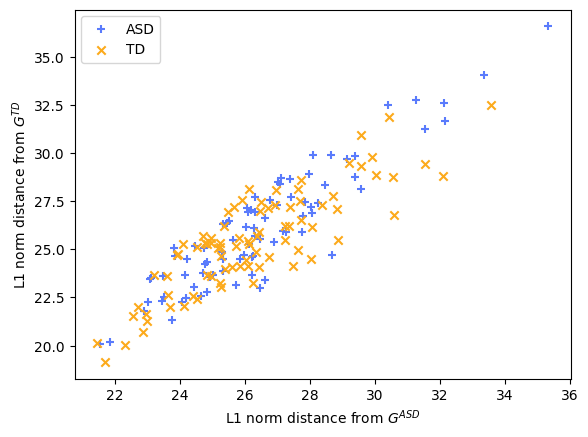

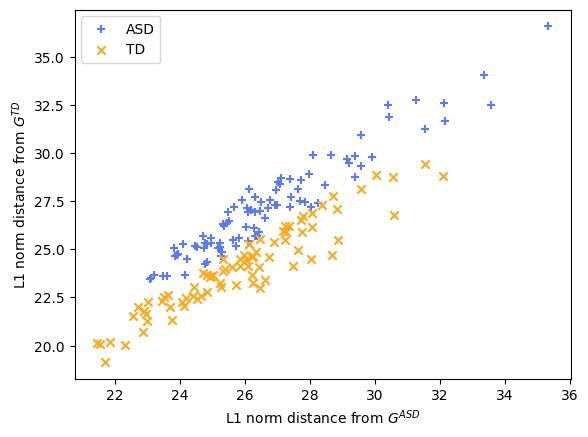

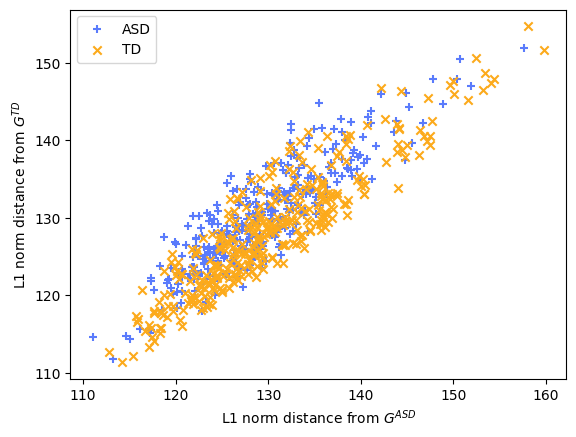

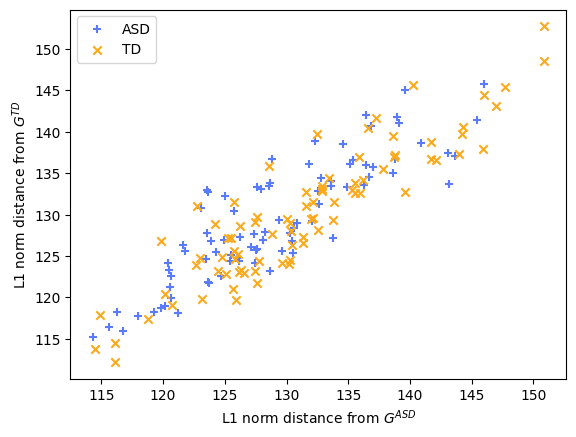

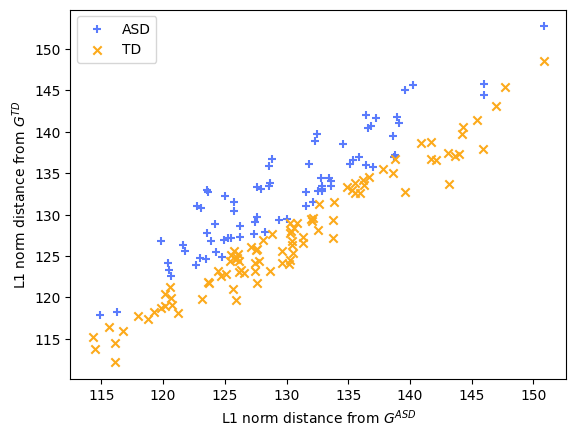

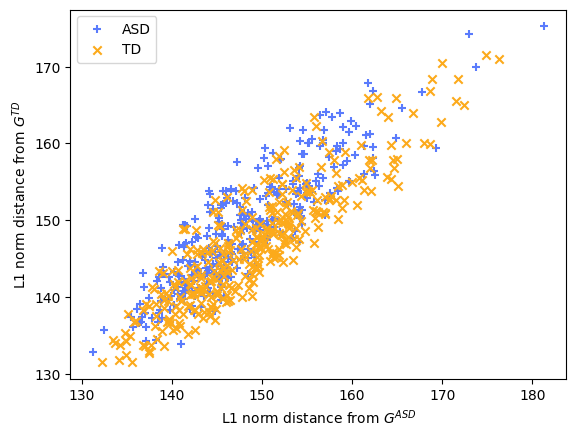

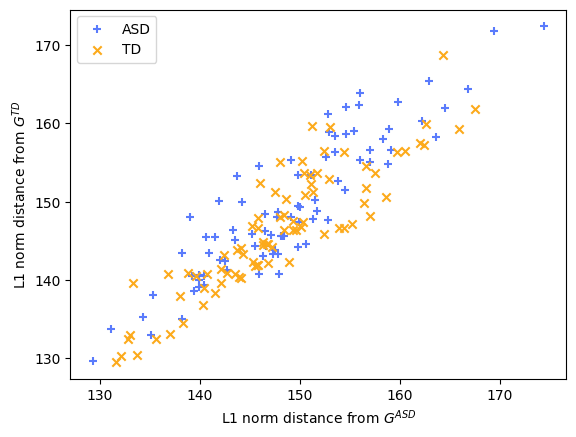

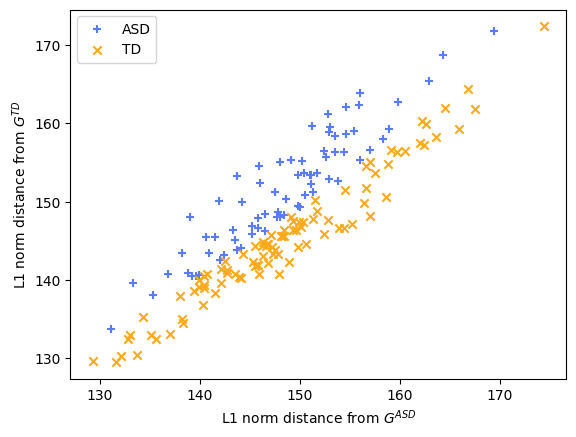

In [12]:
import nested_cv
# Set up possible values of parameters to optimize over
p_grid = {"SVC": {"C": [0.1, 1, 100], "gamma": [0.00001, 0.0001, 0.001]},
          "ContrastSubgraphTransformer": {
            "a_label": ["ASD"],
            "b_label": ["TD"],
            "alpha": [None],
            "alpha2": [None],
            "percentile": [70, 75, 80, 85, 90],
            "percentile2": [70, 75, 80, 85, 90],
            "solver": [qp],
            "problem": [2],
            "num_cs": [1],
            }
          }

pipe = [ContrastSubgraphTransformer, StandardScaler, SVC]


inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = nested_cv.classify(X=graphs, y=labels, pipeline_steps=pipe, step_params=p_grid, outer_cv=outer_cv, inner_cv=inner_cv, plot_prefix=DATASET_NAME)
results